In [485]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import h5py
import astropy.constants as cons
from matplotlib.colors import LogNorm
import astropy.units as u
import pandas as pd
import scipy.optimize as opt
#all of the important fundamental constants are put into cgs units just for convenience
c=cons.c.cgs.value
G=cons.G.cgs.value
h=cons.h.cgs.value
hbar=cons.hbar.cgs.value
Msun=cons.M_sun.cgs.value
Rsun=cons.R_sun.cgs.value
Rearth=cons.R_earth.cgs.value
mp=cons.m_p.cgs.value
me=cons.m_e.cgs.value
mn=cons.m_n.cgs.value
kB=cons.k_B.cgs.value
mu_e=2 #mean mass per electron for He-core or C/O core composition
m_u = 1/cons.N_A.cgs.value #atomic mass unit in grams

## part b

In [486]:
def P_from_rho(rho):
    x = x_from_rho(rho)
    return P_from_x(x)
def P_from_x(x):
    lamb = hbar/(me*c)
    return me*c**2/(lamb**3)*phi_from_x(x)
def phi_from_x(x):
    return (1/(8*np.pi**2))*(x*np.sqrt(1+x**2)*((2*x**2)/3-1)+np.log(x+np.sqrt(1+x**2)))
def x_from_rho(rho):
    lamb = hbar/(me*c)
    return lamb*(3*np.pi**2*rho/(m_u*mu_e))**(1/3)

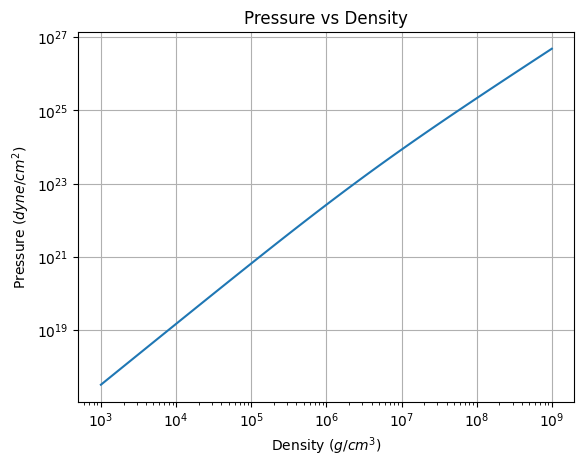

In [487]:
rho = np.logspace(3,9,100)
P = P_from_rho(rho)
plt.plot(rho, P)
plt.title("Pressure vs Density")
plt.xlabel("Density ($g/cm^3$)")
plt.ylabel("Pressure ($dyne/cm^2$)")
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.show()

## part c

In [488]:
def newton_raphson(func, dfunc, x0, tol=1e-10, max_iter=1000):
    #print("Starting Newton-Raphson with initial guess:", x0)
    x = x0
    xHist = np.array([x0])
    fxHist = np.array([0])
    dfxHist = np.array([0])
    for i in range(max_iter):
        fx = func(x)
        dfx = dfunc(x)
        if dfx == 0:
            raise ValueError("Derivative is zero. No solution found.")
        x_new = x - fx/dfx
        xHist = np.append(xHist, x_new)
        fxHist = np.append(fxHist, fx)
        dfxHist = np.append(dfxHist, dfx)
        #if i % 10 == 0:
        #    print(f"Iteration {i}: x = {x_new}, f(x) = {fx}, f'(x) = {dfx}, step = {x_new - x}")
        if abs(x_new - x) < tol:
            return x_new
        
        if np.isnan(x_new) or np.isinf(x_new):
            
            print("NaN or Inf detected. No solution found. Returning last estimate.")
            df = pd.DataFrame({"x": xHist, "f(x)": fxHist, "f'(x)": dfxHist})
            df.to_csv("newton_raphson_debug.csv", index=False)
            raise ValueError("NaN or Inf encountered in computation.")
            #return x
        if x_new <= 0:
            print("Non-physical negative or zero value encountered. No solution found. Returning last estimate.")
            
            return x
        else:
            x = x_new

    print("Maximum iterations reached. No solution found. Returning last estimate.")
    return x

In [489]:
def rho_from_P(Pin, tol=1e-5):
    #print(f"Finding rho for P = {Pin}")
    #in the following cases, r represents rho
    func = lambda r:Pin-P_from_rho(r)
    
    #df/dr = dP/dphi*dphi/dx*dx/dr
    dxdr = lambda r: (hbar/(me*c))*((3*np.pi**2/(m_u*mu_e))**(1/3))*1/(3*r**(2/3))
    dpdphi = me*c**2/(hbar/(me*c))**3
    # I did the derivative by hand originally, but I messed it up I think by forgetting a sign somewhere, this is from derivative calculator
    dphidx = lambda x: (1/(3*np.pi**2)) * x**4 / np.sqrt(1+x**2)
    dfunc = lambda r: -dpdphi*dphidx(x_from_rho(r))*dxdr(r)
    

    if Pin>=P_from_rho(1e6):
        k = 3**(1/3)*np.pi**(2/3)*hbar*c/(4*mu_e**(4/3)*m_u**(4/3))
        r0 = (Pin/k)**(3/4)
    else:
        k = 3**(2/3)*np.pi**(4/3)*hbar**2/(5*mu_e**(5/3)*m_u**(5/3)*me)
        r0 = (Pin/k)**(3/5)
    r_sol = newton_raphson(func, dfunc, r0, tol=tol)
    #r_sol = opt.newton(func, r0,tol=tol)
    return r_sol

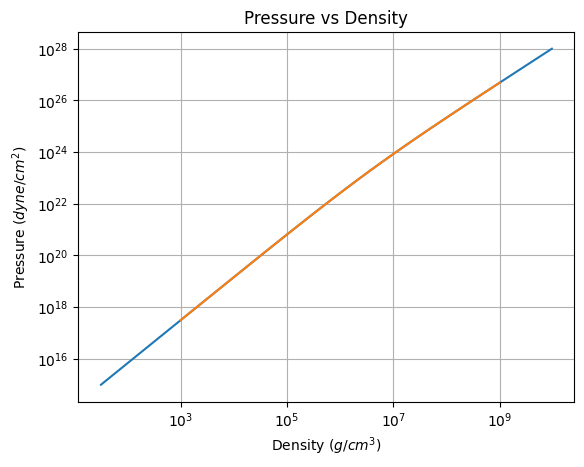

In [490]:
#demonstrating that rho_from_P is properly the inverse of P_from_rho
P = np.logspace(15,28,100)
rho = np.array([rho_from_P(p) for p in P])
plt.plot(rho, P,label="$\\rho(P)$")
rho = np.logspace(3,9,100)
P = P_from_rho(rho)
plt.plot(rho, P,label="$P(\\rho)$")
plt.title("Pressure vs Density")
plt.xlabel("Density ($g/cm^3$)")
plt.ylabel("Pressure ($dyne/cm^2$)")
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.show()

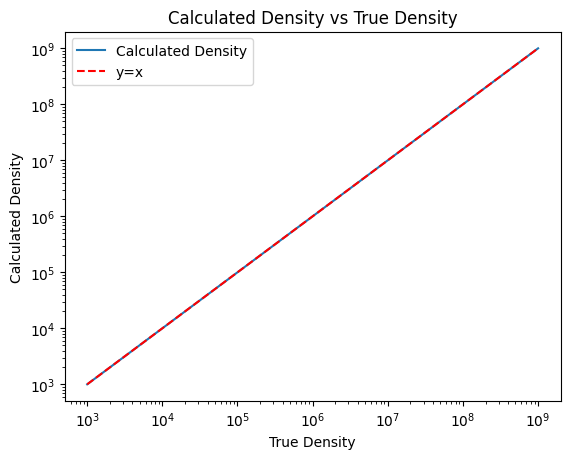

In [491]:
#testing rho_from_P
true_rho = np.logspace(3,9,100)
true_P = [P_from_rho(r) for r in true_rho]
calc_rho = [rho_from_P(p) for p in true_P]
plt.plot(true_rho, calc_rho,label='Calculated Density')
plt.plot(np.logspace(3,9,10), np.logspace(3,9,10), linestyle='--', color='red', label='y=x')
plt.xscale("log")
plt.yscale("log")
plt.title("Calculated Density vs True Density")
plt.xlabel("True Density")
plt.ylabel("Calculated Density")
plt.legend()
plt.show()


## part d

In [492]:
def derivative(r, m, P):
    #returns dm/dr and dP/dr according to equations 1.92 and 1.94
    rho = rho_from_P(P)
    dmdr = 4*np.pi*(r**2)*rho
    dPdr = -G*m*rho/r**2
    return np.stack((dmdr, dPdr))

## part e

In [493]:
def rk4_step(r, m, P, h=0.5):
    #performs a single RK4 step
    k1 = derivative(r, m, P)
    k2 = derivative(r + h/2, m + h/2*k1[0], P + h/2*k1[1])
    k3 = derivative(r + h/2, m + h/2*k2[0], P + h/2*k2[1])
    k4 = derivative(r + h, m + h*k3[0], P + h*k3[1])

    dm = (k1[0] + 2*k2[0] + 2*k3[0] + k4[0]) * h / 6
    dP = (k1[1] + 2*k2[1] + 2*k3[1] + k4[1]) * h / 6

    m_new = m + dm
    P_new = P + dP
    
    return m_new, P_new

## part f

In [494]:
def integrate_star(r0,m0,P0, dr=50000):
    maxIterations=Rsun/dr+10
    i=0
    r = np.array([r0])
    m = np.array([m0])
    P = np.array([P0])
    P_central = P0
    while i < maxIterations:
        # Perform a single RK4 step
        m_new, P_new = rk4_step(r[-1], m[-1], P[-1], h=dr)
        # Update the values for the next iteration
        r = np.append(r, r[-1] + dr)
        m = np.append(m, m_new)
        P = np.append(P, P_new)
        # Check for stopping condition (the pressure is 10^-10 of the central pressure)
        if P[-1]/P_central < 1e-10:
            return r, m, P
        i += 1
    print("Maximum iterations reached in integrate_star. Returning last values.")
    return r, m, P

## part g

### test case because it wasn't working for a while

In [495]:
rho_c = Msun/(Rearth**3)
r0=1e-6*Rearth
P0 = P_from_rho(rho_c) - 2/3*np.pi*G*(rho_c**2)*(r0**2)
m0 = (4/3)*np.pi*(r0**3)*rho_c
r,m,P = integrate_star(r0, m0, P0)
print(r/Rearth, m/Msun, P/P0)


[1.00000000e-06 7.93932519e-05 1.57786504e-04 ... 1.17096100e+00
 1.17103940e+00 1.17111779e+00] [4.18879020e-18 2.09623209e-12 1.64550096e-11 ... 7.64837403e-01
 7.64837404e-01 7.64837405e-01] [1.00000000e+00 9.99999955e-01 9.99999846e-01 ... 2.79244428e-10
 1.40980349e-10 5.50358494e-11]


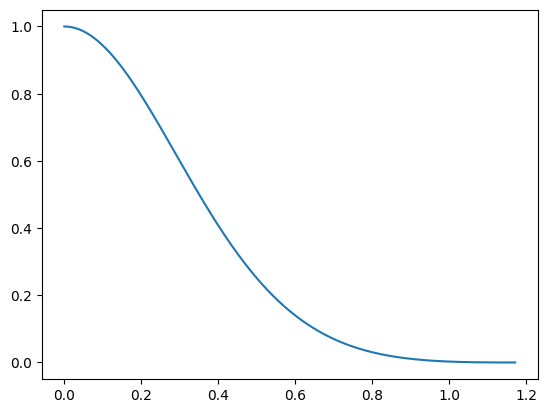

In [496]:
plt.plot(r/Rearth,P/P0)

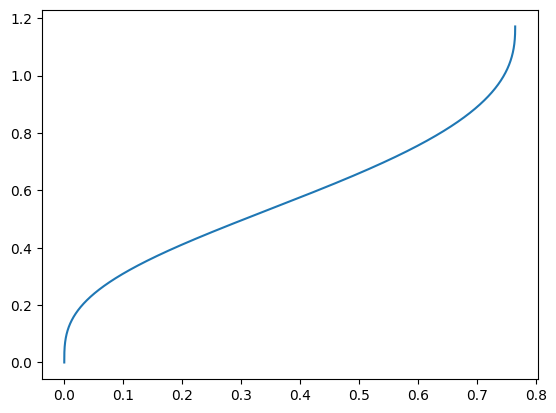

In [497]:
plt.plot(m/Msun,r/Rearth)

### real case

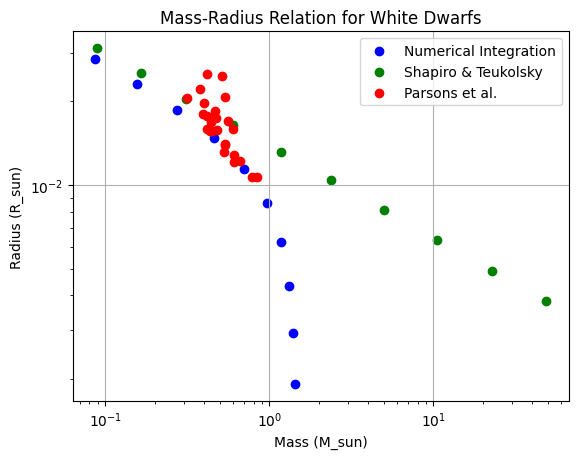

In [498]:
plotR = np.array([])
plotM = np.array([])
plotP = np.array([])
for P0 in np.logspace(20,28,10):
    rho_c = rho_from_P(P0)
    m0 = (4/3)*np.pi*((1e-6*Rsun)**3)*rho_c
    r,m,P = integrate_star((1e-6*Rsun), m0, P0)
    plotR = np.append(plotR, r[-1]/Rsun)
    plotM = np.append(plotM, m[-1]/Msun)
    plotP = np.append(plotP, P0)
    plt.scatter(m[-1]/Msun, r[-1]/Rsun, color='blue',label='Numerical Integration' if P0==plotP[0] else "")
    plt.xscale("log")
    plt.yscale("log")
#saving because it took a while to load and I don't wanna have to do it again
df = pd.DataFrame({"Central Pressure (dyne/cm^2)": plotP, "Mass (M_sun)": plotM, "Radius (R_sun)": plotR})
df.to_csv("mass_radius_data.csv", index=False)
rho_c = np.array([])
for P0 in np.logspace(20,28,10):
    rho_c = np.append(rho_c, rho_from_P(P0))
rs = 1.22*1e9*((rho_c/1e6)**(-1/6))*(mu_e/2)**(-5/6)
rs = rs/Rsun
rm = 0.4964*(rho_c/1e6)**(1/2)*(mu_e/2)**(-5/2)
plt.scatter(rm,rs,label='Shapiro & Teukolsky',color='green')
parsonsM = [0.4756, 0.4164, 0.6579, 0.4817, 0.3780, 0.3160, 0.5618, 0.5354, 0.7816, 0.4475, 0.5340, 0.4406, 0.4656, 0.5290, 0.5964, 0.5140, 0.5338, 0.4146, 0.6050, 0.4150, 0.4393, 0.6098, 0.3916, 0.3977, 0.8400, 0.4356]
parsonsR = [0.01749, 0.02521, 0.01221, 0.01578, 0.02224, 0.02066, 0.01700, 0.02080, 0.01068, 0.01568,0.01398, 0.01747, 0.01840, 0.01310, 0.01594, 0.02470, 0.01401, 0.01768, 0.01278, 0.01590, 0.01680, 0.01207,0.01800, 0.01975, 0.01070, 0.01570]
plt.scatter(parsonsM,parsonsR,label='Parsons et al.',color='red')
plt.xlabel("Mass (M_sun)")
plt.ylabel("Radius (R_sun)")
plt.title("Mass-Radius Relation for White Dwarfs")
plt.legend()
plt.grid()

### printing out data

In [499]:
df

,Central Pressure (dyne/cm^2),Mass (M_sun),Radius (R_sun)
0,1.000000e+20,0.086583,0.028521
1,7.742637e+20,0.156327,0.023101
2,5.994843e+21,0.274836,0.018579
3,4.641589e+22,0.459017,0.014740
4,3.593814e+23,0.704128,0.011429
5,2.782559e+24,0.965166,0.008584
6,2.154435e+25,1.180652,0.006217
7,1.668101e+26,1.321116,0.004342
8,1.291550e+27,1.396795,0.002929
9,1.000000e+28,1.432116,0.001915
